## Libraries and utility functions

In [25]:
import os
import csv
import random
import struct
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats
from typing import Union, Tuple, List

In [26]:
base_path = str(pathlib.Path().absolute())
## images path
mnist_data = base_path+"/data/"

### Utility functions

In [27]:
def read_MNIST(dataset: str="training", path: str="./") -> Union[Tuple[np.ndarray,np.ndarray], np.ndarray]:
    """
    Reads in the MNIST data
    This function allows specification of the part to be read (training/testing/validation)
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'train'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'val'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'test'
        has_labels = True

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load(mnist_data+'X'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load(mnist_data+'y'+file_name_suffix+'.npy')
    
    X = np.float64(X).reshape(X.shape[0],-1)
    y = y.flatten().astype('int')
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X


def show_MNIST_example(image) -> None:
    """
    Render a given numpy.uint8 array of pixel data as an image.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.show()

Training image
Class: 9


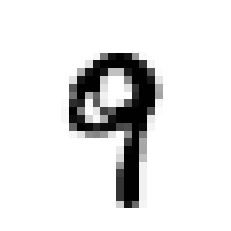

<class 'numpy.ndarray'>


In [28]:
# load the data and visualize a training example
X,y = read_MNIST("training")
print("Training image")
print(f"Class: {y[100]}")
show_MNIST_example(X[100])

X_val,y_val = read_MNIST("validation")
X_test, y_test = read_MNIST("testing")

# let's shuffle the data
np.random.seed(789123)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
print(type(y))


## Decision Trees (ToDo)

In [29]:
class Node:
    """
    Building block of the Decision Tree.
    """
    left = None  # left child
    right = None  # right child
    index = None  # feature index (what is the feature by which we split)
    val = None  # what's the value at which we split
    # Once you arrive at a leaf Node then we use labels
    is_leaf = True
    label = None
    
    def __init__(self, left=None, right=None, index=None, val=None, is_leaf=True, label=None):
        self.left = left
        self.right = right
        self.val = val
        self.is_leaf = is_leaf
        self.label = label
        
    def classify(self, x):
        # this is a recursive function, following the path to the correct leaf
        if self.is_leaf:
            return self.label
        elif x[self.index] <= self.val:
            return self.left.classify(x)
        elif x[self.index] > self.val:
            return self.right.classify(x)
        
            
    def classify_set(self, X):
        # work on examples in a loop 
        res = []
        for sample in X:
            res.append(self.classify(sample))
        return np.asarray(res)
            
    #useful for debugging (on small trees)
    def print_tree(self) -> None:
        print(f"index = {self.index}, val = {self.val}, leaf = {self.is_leaf}, label = {self.label}, left = {self.left}, right = {self.right}")
        if self.left is not None:
            print("left = ", end="")
            self.left.print_tree()
        if self.right is not None:
            print("right = ", end="")
            self.right.print_tree()

In [30]:
# to classify a leaf node take the mode of the labels that arrive at the leaf
def label_leaf(labels):
    classes, counts = np.unique(labels, return_counts=True)
    return classes[np.argmax(counts)]

In [31]:
def best_split_gini(features, labels, min_split_size=5):
    """
    Given a set of feature values (for a single feature) and the corresponding labels,
    find the split that minimizes the (weighted by size) sum of the Gini indices of the two parts
    Note: the combined Gini index is given by len(L)*G[0]+len(U)*G[1]

    Returns: (tau, G, L, U)
        tau : the threshold to split
        G : 2-tuple with the Gini indices of the two parts
        L, U : indices of the points that go into L and U
    """
    
    # sort the feature values (and permute the labels to match that order)
    order = np.argsort(features)
    x = features[order]
    y = labels[order]
    N = len(x)
    classes = np.unique(labels)
    
    # check if there is nothing to split
    if (x[0]==x[-1]) or (len(classes)==1):
        return None, [np.inf,np.inf], range(N), None    
    
    # freq_u maintains frequencies of labels in the (potential) upper portion of the split,
    # and freq_l in the lower
    
    freq_u = np.zeros(np.max(classes) + 1)
    for c in range(len(freq_u)):
        freq_u[c] = np.mean(labels==c)
    freq_l = np.zeros(np.max(classes) + 1)
    
    # now go over the examples in order of increasing feature value;
    # consider splitting before each index where the value changes
    # rather that computing the Gini index from scratch for every split, we will keep track
    # of the running frequencies (as we traverse the list of examples ordered by feature value)
    # and simply recompute Gini from the frequencies each step (much faster)
    
    gini=dict()
    splits=dict()
    for i in range(N-1):
        # update frequencies
        freq_l[y[i]] += 1/N     # This data is removed from the lower range
                                # into the upper range
        freq_u[y[i]] -= 1/N
        
        if x[i+1] > x[i]: # split here, between i and i+1?
            tau = (x[i+1] + x[i]) / 2.0  # a threshold that separates 
                                         # x[i+1] and x[i]
            
            gini_l = np.dot(freq_l, 1-freq_l)
            gini_u = np.dot(freq_u, 1-freq_u)
            
            gini[tau] = (i * gini_l + (N-i) * gini_u, gini_l, gini_u) 
            splits[tau] = i+1 # index of the first element that goes to U

    # now find the best split
    best_tau = -1
    bestval = np.inf
    for t in gini:
        if gini[t][0] < bestval:
            best_tau = t
            bestval = gini[t][0]
    
    L = order[:splits[best_tau]]
    U = order[splits[best_tau]:]
    
    return best_tau, gini[best_tau][1:], L, U

In [32]:
def split_data(X, y, min_split_size=5, M=None):
    # Find the best way to split the data in X (with labels y) by a single feature
    # Don't split if not enough data given min_split_size (return None), otherwise
    # return a dictionary with the following key/value pairs:
    # 'd' -> the index of the feature in X by which we are splitting;
    # 'tau' -> the threshold at which we are splitting that feature;
    # 'Gini' -> the (weighted) Gini index of the two new leaves;
    # 'Gini-parts' -> a 2-tuple (list) of Gini indices of the L and U leaves after the split;
    # 'L' -> indices of the examples in X that go into the lower (left) leaf;
    # 'U' -> same for the upper (right) leaf
    #
    # M specifies the number of features to consider in looking for the best split. If M=None, this means using
    # all the features of X. Otherwise, if say M=50, this means pick 50 features at random and only consider 
    # splitting by these features.
    
    if X.shape[0] < min_split_size:
        return None
    
    D = X.shape[1] # number of features

    if M == None:
        f_lst = [i for i in range(D)]
    else:
        lst = [i for i in range(D)]
        f_lst = [i for i in random.sample(lst, 50)] # randomly get 50 feature index

    min_weighted_gini = None
    best_feature_id = None
    best_feature_tau = None
    best_gini_parts = None
    best_lower_index = None
    best_upper_index = None

    for id in f_lst:
        # id here represents a single feature
        features = X[: , id] #Set of feature values
        tau, gini_parts, L, U = best_split_gini(features, y, min_split_size)

        if (tau == None):
            # when there is nothing to split 
            continue

        num_lower = len(L)
        num_upper = len(U)
        weighted_gini = (gini_parts[0] * num_lower + gini_parts[1] * num_upper) / (num_lower + num_upper)

        if (min_weighted_gini == None) or (weighted_gini < min_weighted_gini):
            min_weighted_gini = weighted_gini
            best_feature_id = id
            best_feature_tau = tau
            best_gini_parts = gini_parts
            best_lower_index = L
            best_upper_index = U
    
    if best_feature_id == None:
        # For all selected features, there is nothing left to split
        return None


    res = dict()
    res['d'] = best_feature_id
    res['tau'] = best_feature_tau
    res['Gini'] = min_weighted_gini
    res['Gini-parts'] = best_gini_parts
    res['L'] = best_lower_index
    res['U'] = best_upper_index
        
    return res

In [33]:
def grow_tree(
    root, 
    data, 
    labels, 
    depth, 
    max_depth=np.inf, 
    min_split_size=1, 
    M=None):
    # this takes root (a node associated with data/labels, and existing at the given depth)
    # and builds a tree rooted at that node, not to exceed the given max_depth
   
    # take a look at Node.classify() to get a better sense how the recursive nature of the tree
    # lets you "drop a point down the tree" and assign a label once you are in the leaf

    if (depth == max_depth):
        no_split=True # we are done, no more splitting below this node
    else:
        best_split = split_data(data, labels, min_split_size,M)
        if best_split==None: # for some reason the splitting code refused to split
            no_split=True
        else: # splitting!
            no_split=False
            
            # COMPLETE CODE: assign values to .index, .val, .is_leaf
            
            root.left = grow_tree(Node(), data[best_split['L']], labels[best_split['L']], depth+1, max_depth,min_split_size,M)
            root.right = grow_tree(Node(), data[best_split['U']], labels[best_split['U']], depth+1, max_depth,min_split_size,M)
            root.index = best_split['d']
            root.val = best_split['tau']
            root.is_leaf = False
            
            
    if no_split: # this is going to be a leaf, let's record this fact and assign it a label to predict
        # COMPLETE CODE HERE  -- what do you need to assign in a leaf?
        root.is_leaf = True
        root.label = label_leaf(labels)
               
    return root

In [34]:
def build_tree(data, labels, max_depth=np.inf, min_split_size=1, M=None):
    root=Node()
    tree=grow_tree(root,
                   data,
                   labels,
                   depth=0, # this will "signal" to the tree growing function that this is the root
                   max_depth=max_depth,
                   min_split_size=min_split_size,
                   M=M)
    return tree

In [20]:
tree = build_tree(X, y, max_depth=10, min_split_size=3, M=None) # may take a few minutes

### Training and validation accuracy for the tree (ToDo)

- **Compute** training and validation accuracies

- **Report** training and validation set accuracies of a single tree, 
    - with **hyperparameters** (max tree depth and minimum size of a leaf) tuned as you see fit (make sure to describe how you tuned them and include the code and output from the process in the notebook). 

In [25]:
predict = tree.classify_set(X)
num_correct = 0
num_total = len(predict)
for i in range(num_total):
    if (y[i] == predict[i]):
        num_correct += 1
train_accuracy = num_correct/num_total
print("The train accuracy is {}".format(train_accuracy))

The train accuracy is 0.9096444444444445


In [26]:
max_depth = [5, 10, 15]
split_size = [3, 5]
best_accuracy = 0
best_depth = 0
best_size = 0
for depth in max_depth:
    for size in split_size:
        tree = build_tree(X, y, max_depth=depth, min_split_size=size, M=None)
        val_predict = tree.classify_set(X_val)
        num_correct = 0
        num_total = len(val_predict)
        for i in range(num_total):
            if (y_val[i] == val_predict[i]):
                num_correct += 1
        val_accuracy = num_correct/num_total

        if(val_accuracy > best_accuracy):
            best_accuracy = val_accuracy
            best_depth = depth
            best_size = size

print("The best accuracy is {}, the best depth is {}, the best size is {}".format(best_accuracy, best_depth, best_size))

The best accuracy is 0.847, the best depth is 10, the best size is 3


In [ ]:
val_predict = tree.classify_set(X_val)
num_correct = 0
num_total = len(val_predict)
for i in range(num_total):
    if (y_val[i] == val_predict[i]):
        num_correct += 1
val_accuracy = num_correct/num_total
print("The accuracy on the val set is {}".format(val_accuracy))

The hyperparameter we choose is max_depth = 10, min_split_size = 3

### Test accuracy (ToDo)

- **Compute and report** the results on test set, for the model built with the chosen values – please don’t be tempted to evaluate the model on test more than once, so be sure you are done with the tuning!

In [35]:
tree = build_tree(X, y, max_depth=10, min_split_size=3, M=None)

In [29]:
test_predict = tree.classify_set(X_test)
num_correct = 0
num_total = len(test_predict)
for i in range(num_total):
    if (y_test[i] == test_predict[i]):
        num_correct += 1
test_accuracy = num_correct/num_total
print("The accuracy on the val set is {}".format(test_accuracy))

The accuracy on the val set is 0.8522


## Prune the Tree (ToDo)

- **Question 4 is a bonus question**. You are encouraged to do it

- Add the code for pruning a tree
- Report the accuracy of the CART tree (with pruning) using hyperparameters (including λ) tuned as you see fit, on the test set; 
- Compare it to the result with the unpruned tree, and comment on the difference, if any.

In [ ]:
# traverse a tree according to the direction
def traverse_tree(root, direction):
    if direction == "right":
        if (root.right == None):
            print("go to a NULL node")
            exit(-1)
        else:
            root = root.right
    else:
        if (root.left == None):
            print("go to a NULL node")
            exit(-1)
        else:
            root = root.left

def check_internal_node(root):
    # check whether the node is an internal node that can be collapsed
    return root.left.is_leaf and root.right.is_leaf

def calculate_leaf_error(root, data, labels):
    error = 0
    label = label_leaf(labels)
    for k in range(len(data)):
        error += (data[k] - label) ** 2

def calculate_error_increase(root, data, labels):
    if (root.is_leaf == True):
        # if the node is alreay a leaf, nothing to collapse
        return None
    if check_internal_node(root):
        # parent of two node, considering collapsing it
        left_data = []
        left_labels = []
        right_data = []
        right_labels = []

        for i in range(len(data)):
            x = data[i]
            y = labels[i]
            if x[root.index] < root.val:
                left_data.append(x)
                left_labels.append(y)
            else:
                right_data.append(x)
                right_labels.append(y)
        left_label = label_leaf(left_labels)
        right_label = label_leaf(right_labels)

        original_error = 0
        for i in range(len(left_data)):
            original_error += ((left_data[i] - left_label) ** 2)
        for j in range(len(right_data)):
            original_error += ((right_data[j] - right_label) ** 2)
        
        new_error = 0
        label = label_leaf(labels)
        for k in range(len(data)):
            new_error += (data[k] - label) ** 2

        error_increase = new_error - original_error
        res = (original_error, new_error, error_increase)
        return res

# collapse an internal node
def prune_one_node(root, data, labels):
    label = label_leaf(labels)

    if ((root.left.is_leaf == True) and (root.right.is_leaf == True)):
        root.left = None
        root.right = None
        root.index = None
        root.val = None
        root.is_leaf = True
        root.label = label

    return root

def collapse_internal_node(root, data, labels):

    # base cases
    if root.is_leaf:
        res = calculate_leaf_error(root)
        return res

    if check_internal_node(root.left) and root.right.is_leaf:
        res_left = calculate_error_increase(root.left)
        right_error = calculate_leaf_error(root.right)
        res = res_left[1] + right_error
        prune_one_node(root.left)
        return res

    if check_internal_node(root.right) and root.left.is_leaf:
        res_right = calculate_error_increase(root.right)
        left_error = calculate_leaf_error(root.left)
        res = res_right[1] + left_error
        prune_one_node(root.right)
        return res
    
    if (check_internal_node(root.left) and check_internal_node(root.right)):
        res_left = calculate_error_increase(root.left)
        res_right = calculate_error_increase(root.right)

        if (res_left[2] < res_right[2]):
            # the increaes error is smaller if we prune the left tree
            prune_one_node(root.left)
            return (res_left[1] + res_right[0])
        else:
            prune_one_node(root.right)
            return (res_right[1] + res_left[0])



    

    if root.left.is_leaf and (root.right.is_leaf == False):
        collapse_internal_node(root.right)

    if root.right.is_leaf and (root.left.is_leaf == False):
        collapse_internal_node(root.left)
   


# Bagging Section

In [11]:
# Helper functions for running bagging ensembles on data
def apply_ensemble(trees, data, C=10):
    """Returns the labels after applying the ensemble"""

    # apply every tree in the ensemble to classify the result and put it 
    # into a list, then each such list becomes an elemenent in the array
    # res.shape[0] = number of trees
    # res.shape[1] = number of samples 
    res = np.array([tree.classify_set(data) for tree in trees])
    yhat = np.zeros(res.shape[1])
    for i in range(res.shape[1]):
        # for a sample, if it's most commonly been attributed to a certain class
        # by the ensemble, count that data into that class
        yhat[i]=np.argmax(np.bincount(res[:,i]))
    return yhat.astype(int)

def evaluate_ensemble(trees, data, labels):
    """Returns the accuracy of the ensemble"""
    return np.mean(apply_ensemble(trees, data) == labels)

### Create ensemble (ToDo)

In [13]:
def bootstrap(X, y):
    N = X.shape[0]
    lst = np.random.randint(N, size = N)
    return X[lst], y[lst]

In [14]:
# Bagging
def create_ensemble(X, y, max_depth=10, min_split_size=1, num_trees=5, M_fraction=0.5):
    """
    M_fraction gives M as a fraction of d (# of features in X)
    """
    N, d = X.shape
    assert 0 < M_fraction < 1.0
    M = int(d*M_fraction)  # compute the actual M (number of features to consider in each node)
    
    trees = []
    for _ in tqdm(range(num_trees)): # this will show progress bar as you build the forest
        
        # COMPLETE CODE HERE -- construct tree
        X_sample, y_sample = bootstrap(X,y)
        tree = build_tree(X_sample, y_sample, max_depth, min_split_size, M)
        trees.append(tree)
        
    return trees

#### NB: This step takes a while

In [15]:
ensemble = create_ensemble(X, y, max_depth=15, min_split_size=5, num_trees=30, M_fraction=0.05)

100%|██████████| 30/30 [27:33<00:00, 55.12s/it]


### Train/Validation Accuracy (ToDo)

- **Compute** the training and validation accuracy

- **Report** the training and validation set accuracies of your ensemble. You should aim to get at least **90%** validation accuracy.
- **Plot** the val accuracy as a function of ensemble size

In [16]:
train_acc = evaluate_ensemble(ensemble, X, y)
val_acc = evaluate_ensemble(ensemble, X_val, y_val)

print("Training accuracy is {}".format(train_acc))
print("Val accuracy is {}".format(val_acc))

Training accuracy is 0.9973333333333333
Val accuracy is 0.9518666666666666


Tuning for a good value of M

In [17]:
M_lst = [0.01, 0.05, 0.1]

best_M = 0
best_acc = 0

for m in M_lst:
    ensemble = create_ensemble(X, y, max_depth=15, min_split_size=5, num_trees=30, M_fraction=m)
    val_acc = evaluate_ensemble(ensemble, X_val, y_val)
    if (val_acc > best_acc):
        best_acc = val_acc
        best_M = m
print("The best accuracy rate on validation set is{}, the best M is{}".format(best_acc, best_M))

100%|██████████| 30/30 [24:41<00:00, 49.39s/it]


The best accuracy rate on validation set is0.9536, the best M is0.1


#### The best accuracy achieved on the val set is 0.9536, and the best M is 0.1.

### Test Accuracy (ToDo)
- **Compute and report** the results of your ensemble on the test set. Again, don’t do it more than once!

In [19]:
test_acc = evaluate_ensemble(ensemble, X_test, y_test)
print("Test accuracy is {}".format(test_acc))

Test accuracy is 0.9564


The accuracy on the test set is 0.9564.

## Effect of the size of your ensemble (ToDo)

- **Show the effect of the size of your ensemble as follows**: 
    - Let T be the number of trees in your ensemble. 
    - For t = 1, . . . , T 
        - **Compute** the validation set accuracy of the partial ensemble consisting of trees 1, . . . , t
        - **Plot** this as a function of t. 
- Discuss what this tells you and how it may inform tuning T.

*Advice: Do not re-run the creation of the forest for T = 1, 2, . . .! rather, take your existing ensemble and compute the accuracy of the partial ensembles consisting of only the first tree; the first two trees; etc.*

In [21]:
ensemble

sub_tree = []
res_lst = []
for i in range(len(ensemble)):
    sub_tree.append(ensemble[i])
    res = evaluate_ensemble(sub_tree, X_val, y_val)
    res_lst.append(res)
res_lst

[0.7934666666666667,
 0.7848,
 0.8517333333333333,
 0.8826666666666667,
 0.8978666666666667,
 0.9094,
 0.9170666666666667,
 0.9222666666666667,
 0.9252,
 0.9281333333333334,
 0.9328,
 0.9364,
 0.9382666666666667,
 0.9404666666666667,
 0.9416,
 0.9432,
 0.9448,
 0.9456666666666667,
 0.9466,
 0.9482,
 0.9493333333333334,
 0.9494,
 0.9509333333333333,
 0.9508,
 0.9510666666666666,
 0.9517333333333333,
 0.9526,
 0.9536,
 0.9534666666666667,
 0.9536]

Text(0, 0.5, 'Val Accuracy')

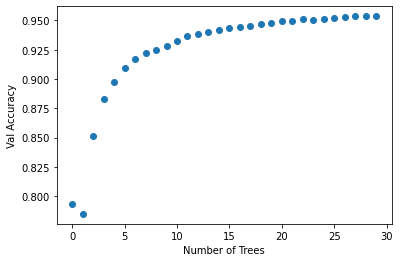

In [24]:
x = [i for i in range(len(ensemble))]
plt.scatter(x, res_lst)
plt.xlabel("Number of Trees")
plt.ylabel("Val Accuracy")

When T is small, the accuracy rate rises rapidly when T gets larger. This makes sense because each tree should have low bias but high variance. Hence, combining them will greatly reduce the variance and drive the validation accuracy higher.However, when T is sufficiently lagre (in our example, when T > 20), the accuracy rate starts to converge. Hence, when T gets too large, the algorithm wastes computation power instead of adding much to the accuracy rate. When tuning T, we need to start from a relatively small T, increase the number of T, and if the val accuracy rate converges, we should stop increasing T anymore.